# Project Notebook - Machine Learning I

### Libraries

In [30]:
import pandas as pd
import numpy as np
import openml
from AdaBoostWorkyWorky import AdaBoost
from sklearn.model_selection import KFold, train_test_split, learning_curve
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, roc_curve, roc_auc_score
import scipy.stats as ss
import matplotlib.pyplot as plt


### Get the datasets to use throughout the project

Function to read a dataset from [OpenML-CC18 Curated Classification benchmark](https://www.openml.org/search?type=study&sort=tasks_included&study_type=task&id=99) givent its Task ID and return the corresponding Pandas Dataframe

In [31]:
def getDataset(task_id):
    suite = openml.study.get_suite(99)
    task = openml.tasks.get_task(task_id)    
    dataset = openml.datasets.get_dataset(task.dataset_id)

    X, y, categorical_indicator, attribute_names = dataset.get_data(
        dataset_format="array", target=dataset.default_target_attribute
    )

    df = pd.DataFrame(X, columns=attribute_names)
    # converter:
    #   0 -> -1
    #   1 -> 1
    df['target'] = 2*y-1 
    # erase rows with NaN values
    df = df.dropna(how='any', axis=0)

    return df

Description of the datasets used in this project:
- A
- B
- C

In [32]:
datasets = [
    ("Task ID = 15", getDataset(15)),
    ("Task ID = 24", getDataset(24)),
    ("Task ID = 3904", getDataset(3904))
]

### Performance evaluation of AdaBoost

In [33]:
# function to perform cross validation on a set of algorithms ("algs")
def run_cv(X,y,algs,nfolds=10):
    results = {}
    kf = KFold(n_splits=nfolds, shuffle=True, random_state=1111)
    for algo_name, algo in algs:
        results[algo_name] = []
        for fold, (train_idx, test_idx) in enumerate(kf.split(X)):
            X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
            y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
            algo.fit(X_train, y_train)
            y_pred = algo.predict(X_test)
            results[algo_name].append(accuracy_score(y_test, y_pred))
    results_df = pd.DataFrame.from_dict(results)
    return results_df

In [34]:
# running 10-fold cross validation for all datasets and checking accuracy

for ds_id, ds in datasets:
    X = ds.drop(columns=['target'], axis=1)
    y = ds['target']

    algs = [("AdaBoost", AdaBoost())]
    result = run_cv(X, y, algs)
    print(f"Mean accuracy for dataset wiht {ds_id} in 10-fold CV: {np.mean(result['AdaBoost']):.5f}")

Mean accuracy for dataset wiht Task ID = 15 in 10-fold CV: 0.96343
Mean accuracy for dataset wiht Task ID = 24 in 10-fold CV: 0.97520
Mean accuracy for dataset wiht Task ID = 3904 in 10-fold CV: 0.80910


In [35]:
# function to plot the Confusion Matrix of a fitted model
def plot_cm(model_fit,X_test,y_test):
    y_pred = model_fit.predict(X_test)
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot()

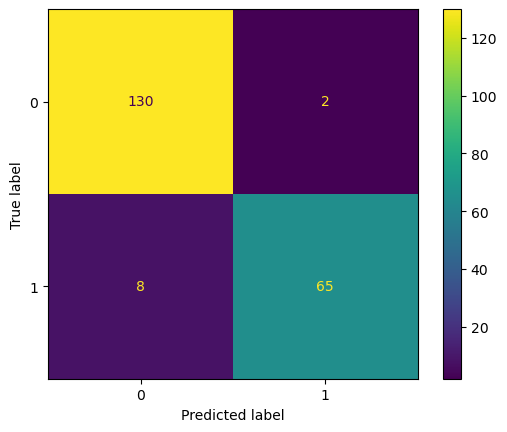

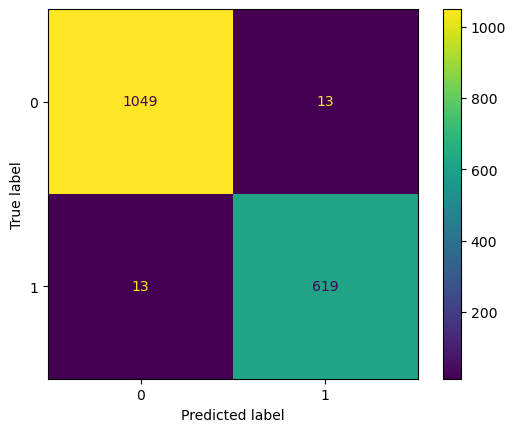

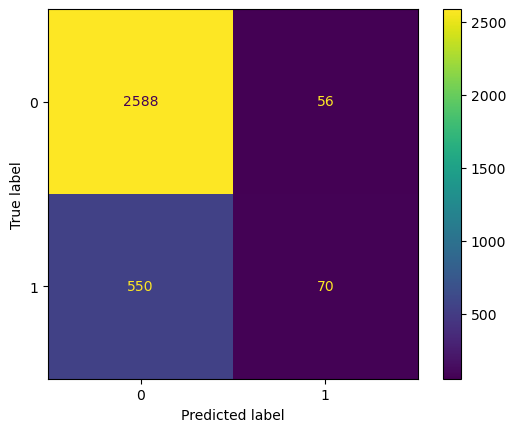

In [36]:
# confusion matrix for each dataset
for ds_id, ds in datasets:
    X = ds.drop(columns=['target'], axis=1)
    y = ds['target']

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1111)
    ab = AdaBoost()
    ab.fit(X_train, y_train)
    plot_cm(ab, X_test, y_test)


In [37]:
# unable to test ROC Curve because our implementation doesnt have a "predict_proba" method

In [40]:
# function to plot the Learning Curve of a fitted model
def plot_learning_curves(model, X, y,title=''):
    tr_size = np.linspace(0.1,1.0,10)

    train_sizes, train_scores, test_scores = learning_curve(model, X, y, scoring='accuracy', train_sizes=tr_size)

    for tr_size, cv_tr_score, cv_ts_score in zip(train_sizes,train_scores,test_scores):
        print(
            "Train size:",tr_size,"Train score:",
            round(cv_tr_score.mean(),3),"Test score:",
            round(cv_ts_score.mean(),3)
        )

    train_mean = np.mean(train_scores, axis=1)
    train_std = np.std(train_scores, axis=1)
    test_mean = np.mean(test_scores, axis=1)
    test_std = np.std(train_scores, axis=1)

    plt.figure(figsize=(8, 6))
    plt.plot(train_sizes, train_mean, 'o-', \
    color='blue', label='Training score')
    plt.plot(train_sizes, test_mean, 'o-', \
    color='green', label='Test score')
    plt.fill_between(train_sizes, train_mean - train_std, \
    train_mean + train_std, alpha=0.1, color='blue')
    plt.fill_between(train_sizes, test_mean - test_std, \
    test_mean + test_std, alpha=0.1, color='green')
    plt.xlabel('Training examples')
    plt.ylabel('Accuracy')
    plt.legend(loc='best')
    plt.title('Learning Curves '+title)
    plt.show()


In [ ]:
# ROC Cruve for each dataset
for ds_id, ds in datasets:
    X = ds.drop(columns=['target'], axis=1)
    y = ds['target']

    ab = AdaBoost()
    plot_learning_curves(ab, X, y, title=f"Learning Curve for data set with {ds_id}")